In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from google.colab import widgets
import time

## Grid Environment Definition

Includes both deterministic and stochastic environments

In [2]:
class GridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self, stochastic = False):
    '''
    Defines the initialization of the environment.

    Input
    ------
    stochastic: [bool] True, if stochastic environment
    '''
    self.observation_space = spaces.Discrete(15)
    self.action_space = spaces.Discrete(4)
    self.max_timesteps = 20
    self.stochastic = stochastic

  def reset(self):
    '''
    Reset the environment to initial state.

    '''
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [2, 4]
    self.hole1_pos = [1,3]
    self.hole2_pos = [2,1]
    self.candy1_pos = [0,3]
    self.candy2_pos = [1,1]
    self.state = np.zeros((3, 5))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.hole1_pos)] = 0.25
    self.state[tuple(self.hole2_pos)] = 0.25
    self.state[tuple(self.candy1_pos)] = 0.75
    self.state[tuple(self.candy2_pos)] = 0.75
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()
    return observation

  def step(self, action):
    '''
    Define an execution of one timestep within the environment

    Input
    ------
    action: [int] action from the action space [0,1,2,3]

    Returns
    ------
    observation, reward, done, info
    '''
    # self.state = np.random.choice(self.observation_space.n)
    info = {}

    if(self.stochastic):
      info['action_given'] = action
      if (np.random.uniform(0,1)<0.9):
        action = action
      else:
        action = self.action_space.sample()
      info['action_taken'] = action

    if action == 0:
      self.agent_pos[0] += 1
    if action == 1:
      self.agent_pos[0] -= 1
    if action == 2:
      self.agent_pos[1] += 1
    if action == 3:
      self.agent_pos[1] -= 1
    
    # print(f'before clipping: {self.agent_pos}')
    self.agent_pos[0] = np.clip(self.agent_pos[0], 0, 2)
    self.agent_pos[1] = np.clip(self.agent_pos[1], 0, 4)
    self.agent_pos = np.array(self.agent_pos)
    # print(f'after clipping: {self.agent_pos}')
    self.state = np.zeros((3,5))
    self.state[tuple(self.candy1_pos)] = 0.75
    self.state[tuple(self.candy2_pos)] = 0.75
    self.state[tuple(self.hole1_pos)] = 0.25
    self.state[tuple(self.hole2_pos)] = 0.25
    self.state[tuple(self.goal_pos)] = 0.5

    reward = 0
    if (self.agent_pos == self.goal_pos).all():
      reward = +10 #deterministic reward
      self.state[tuple(self.agent_pos)] = 0.9
    elif (self.agent_pos == self.candy1_pos).all():
      reward = +5 #deterministic reward
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward = +2
        else:
          reward = +5
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.candy2_pos)] = 0.75
    elif (self.agent_pos == self.candy2_pos).all():
      reward = +7 #deterministic reward
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward = +2
        else:
          reward = +7
      self.state[tuple(self.candy1_pos)] = 0.75
      self.state[tuple(self.agent_pos)] = 1
    elif (self.agent_pos == self.hole1_pos).all():
      reward = -3 #deterministic reward
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.9):
          reward = -3
        else:
          reward = +6
      self.state[tuple(self.hole1_pos)] = 1
      self.state[tuple(self.hole2_pos)] = 0.25
    elif(self.agent_pos == self.hole2_pos).all():
      reward = -3 #deterministic reward
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.9):
          reward = -3
        else:
          reward = +6
      self.state[tuple(self.hole1_pos)] = 0.25
      self.state[tuple(self.hole2_pos)] = 1
    else:
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.candy1_pos)] = 0.75
      self.state[tuple(self.candy2_pos)] = 0.75
      self.state[tuple(self.hole1_pos)] = 0.25
      self.state[tuple(self.hole2_pos)] = 0.25
      self.state[tuple(self.goal_pos)] = 0.5

    observation = self.state.flatten()

    self.timestep += 1
    done = True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False

    return observation, reward, done, info

  def render(self):
    '''
    Render the GridEnvironment
    '''
    plt.imshow(self.state)

## Deterministic

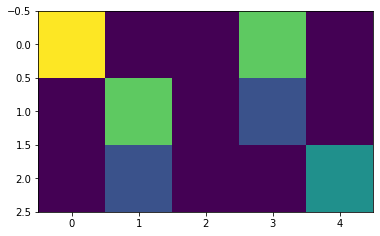

In [3]:
env = GridEnvironment()
obs = env.reset()
env.render()

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: left


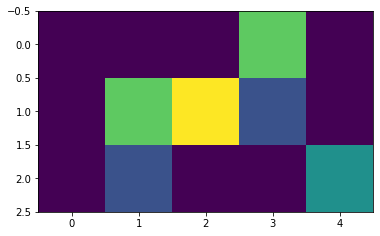

<IPython.core.display.Javascript object>

In [4]:
env.reset()
actions_given = []
rewards = []
observations = []
action_dict = {
    0: 'down',
    1: 'up',
    2: 'right',
    3: 'left',
}

output_grid = widgets.Grid(1,1)
for _ in range(10):
  action = np.random.randint(0,4)
  observation, reward, done, info = env.step(action)
  actions_given.append(action)
  rewards.append(reward)
  observations.append(observation)
  with output_grid.output_to(0,0):
    output_grid.clear_cell()
    env.render()
    print(f'Reward: {reward}, Action taken: {action_dict[action]}')
  time.sleep(1)

In [5]:
actions_given

[2, 2, 2, 2, 1, 3, 0, 2, 3, 3]

In [6]:
rewards

[0, 0, 5, 0, 0, 5, -3, 0, -3, 0]

## Stochastic Environment

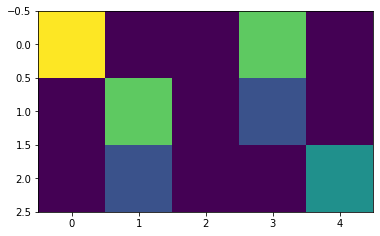

In [7]:
env = GridEnvironment(stochastic=True)
obs = env.reset()
env.render()

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action given: right, Action taken: right


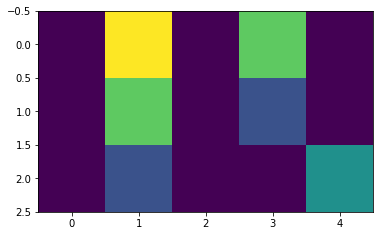

<IPython.core.display.Javascript object>

In [8]:
env.reset()
actions_given = []
actions_taken = []
rewards = []
observations = []
action_dict = {
    0: 'down',
    1: 'up',
    2: 'right',
    3: 'left',
}

output_grid = widgets.Grid(1,1)
for _ in range(10):
  action = np.random.randint(0,4)
  observation, reward, done, info = env.step(action)
  action_taken = info['action_taken']
  actions_given.append(action)
  actions_taken.append(action_taken)
  rewards.append(reward)
  observations.append(observation)
  with output_grid.output_to(0,0):
    output_grid.clear_cell()
    env.render()
    print(f'Reward: {reward}, Action given: {action_dict[action]}, Action taken: {action_dict[action_taken]}')
  time.sleep(1)

In [9]:
actions_given

[1, 1, 1, 0, 0, 1, 3, 1, 3, 2]

In [10]:
actions_taken

[1, 2, 1, 0, 0, 1, 3, 1, 3, 2]

In [11]:
rewards

[0, 0, 0, 7, -3, 2, 0, 0, 0, 0]